In [1]:
import sys
sys.path.append('../../..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
import adamod
import torch
import torch.nn.functional as F


from torch.utils.data import DataLoader
from collections import OrderedDict
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from MogrifierLSTM import MogrifierLSTMCell
from utils.dataset import NCDFDatasets
from utils.trainer import Tester
from utils.trainer import Trainer
from datetime import datetime
from pytorch_model_summary import summary


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()
device

device(type='cuda', index=0)

In [4]:
batch_size = 25
validation_split = 0.2
test_split = 0.2
dropout_rate = 0.2
hidden_size = 32*32
mogrify_rounds = 5
param = {'encoder_layer_size': 3, 'decoder_layer_size': 3, 'kernel_size': 5, 'filter_size': 32}

In [5]:
import xarray as xr
data_path = '../../../data/dataset-ucar-1979-2015-seq5-ystep5.nc'
dataset = xr.open_dataset(data_path)
print(dataset)

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 32, lon: 32, sample: 54047, time: 5)
Coordinates:
  * lat      (lat) int32 -54 -52 -50 -48 -46 -44 -42 -40 ... -6 -4 -2 0 2 4 6 8
  * lon      (lon) int32 278 280 282 284 286 288 290 ... 330 332 334 336 338 340
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have air temperature values and are separable...


In [6]:
#In these experiments y has dimensions [batch, channel, lat, lon] as opposed to [batch, channel, time, lat, lon] to
#avoid dimension conflict with conv kernels
data = NCDFDatasets(dataset, val_split = 0.2, test_split = 0.2, cut_y=True)
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [7]:
print("-----Train-----")
print("X : ", train_data.x.shape)
print("Y : ", train_data.y.shape)
print("-----Val-----")
print("X : ", val_data.x.shape)
print("Y : ", val_data.y.shape)
print("-----Test-----")
print("X : ", test_data.x.shape)
print("Y : ", test_data.y.shape)

-----Train-----
X :  torch.Size([32429, 1, 5, 32, 32])
Y :  torch.Size([32429, 1, 32, 32])
-----Val-----
X :  torch.Size([10809, 1, 5, 32, 32])
Y :  torch.Size([10809, 1, 32, 32])
-----Test-----
X :  torch.Size([10809, 1, 5, 32, 32])
Y :  torch.Size([10809, 1, 32, 32])


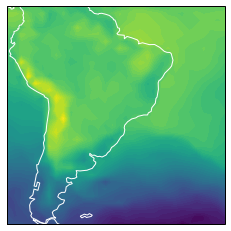

In [8]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
#sample, ch, time, lat, lon
sst = train_data.y[0, 0, :, :]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')

plt.show()

In [9]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

def init_seed(seed):
    np.random.seed(seed)
    
init_seed = init_seed(seed)

In [10]:
params = {'batch_size': batch_size,
          'num_workers': 4,
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_data, shuffle=True, **params)
val_loader = DataLoader(dataset=val_data, shuffle=False, **params)
test_loader = DataLoader(dataset=test_data, shuffle=False, **params)

In [11]:
class Mish(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [12]:
class CustomConv2d(torch.nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1,
                 bias=False, padding_mode='zeros', weight=None):
        super().__init__(in_channels, out_channels, kernel_size, stride=stride,
                 padding=padding, dilation=dilation,
                 bias=bias, padding_mode=padding_mode)
        
        self.padding = [kernel_size // 2, kernel_size // 2]
        
    def forward(self,input, weight=None):
        if (weight is not None):
            return F.conv2d(input, weight.permute(1,0,2,3), self.bias, self.stride,
                        self.padding, self.dilation)
        else:
            return F.conv2d(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation)

In [13]:
class EncoderCNN(torch.nn.Module):
    def __init__(self, layer_size, kernel_size, initial_out_channels, initial_in_channels, device):
        super(EncoderCNN, self).__init__()
        self.device = device
        self.layer_size = layer_size
        self.conv_layers = torch.nn.ModuleList()
        self.mish_layers = torch.nn.ModuleList()
        self.bn_layers = torch.nn.ModuleList()
        self.decode_bn_layers = torch.nn.ModuleList()
        
        in_channels = initial_in_channels
        out_channels = initial_out_channels
        for i in range(self.layer_size):
            self.conv_layers.append(CustomConv2d(in_channels = in_channels, out_channels = out_channels,
                                                kernel_size = kernel_size))
            self.mish_layers.append(Mish())
            self.bn_layers.append(torch.nn.BatchNorm2d(out_channels))
            self.decode_bn_layers.append(torch.nn.BatchNorm2d(out_channels))
            in_channels = out_channels
            
        self.conv_reduce = CustomConv2d(in_channels = in_channels, out_channels = 1,
                                                kernel_size = 1)
            
            
    def forward(self, x, decode=False):
        if (decode):
            x = self.conv_reduce(x, self.conv_reduce.weight)
            for i in range(self.layer_size-1, -1, -1):
                x = self.decode_bn_layers[i](x)
                x = self.mish_layers[i](x)
                x = self.conv_layers[i](x, self.conv_layers[i].weight)
        else:
            for i in range(self.layer_size):
                x = self.conv_layers[i](x)
                x = self.bn_layers[i](x)
                x = self.mish_layers[i](x)
            x = self.conv_reduce(x)
        return x

In [14]:
class STModel(torch.nn.Module):
    def __init__(self, encoder_layer_size, kernel_size, out_channels, in_channels, input_width, input_height, hidden_size
                 , device):
        super(STModel, self).__init__()
        self.device = device
        self.encoder = EncoderCNN(layer_size = encoder_layer_size, kernel_size = kernel_size,
                                initial_out_channels = out_channels,
                                initial_in_channels = in_channels, device=device)
        self.recurrent_encoder = torch.nn.LSTMCell(input_width*input_height, hidden_size);
        #self.recurrent_decoder = torch.nn.LSTMCell(input_width*input_height, hidden_size);
       
        
    def forward(self, x, states):
        batch, channel, time, lat, lon = x.size()
        x = x.view(batch*time, channel, lat, lon)
        x = self.encoder(x)
        
        x = x.view(batch, time, -1)
        h = states[0]
        c = states[1]
        for i in range(time):
            h,c = self.recurrent_encoder(x[:,i,:],(h,c))
            
        x = h.contiguous().view(batch, channel, lat, lon)
        x = self.encoder(x, decode=True)
        return x.view(batch, channel, lat, lon)
        

In [15]:
class RMSELoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [16]:
model = STModel(encoder_layer_size = param['encoder_layer_size'], kernel_size = param['kernel_size'], out_channels = param['filter_size'],
                in_channels = train_data.x.shape[1], input_width = train_data.x.shape[3], 
                input_height = train_data.x.shape[4], hidden_size = hidden_size, device=device).to(device)
criterion = RMSELoss()
#optimizer_params = {'lr': 0.001}
#optimizer = torch.optim.Adam(net.parameters(), **optimizer_params)
opt_params = {'lr': 0.001, 
              'beta3': 0.999}
optimizer = adamod.AdaMod(model.parameters(), **opt_params)
model

STModel(
  (encoder): EncoderCNN(
    (conv_layers): ModuleList(
      (0): CustomConv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
      (1): CustomConv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
      (2): CustomConv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
    )
    (mish_layers): ModuleList(
      (0): Mish()
      (1): Mish()
      (2): Mish()
    )
    (bn_layers): ModuleList(
      (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (decode_bn_layers): ModuleList(
      (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(32, e

In [17]:
model_path = os.path.join('../../../models/CFSR/1_step/STTSModel_3D' + '_' + datetime.now().strftime('m%md%d-h%Hm%Ms%S') + '.pth.tar')
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, 100, device, model_path, recurrent_model=True, cut_output=True, patience=5)


In [18]:
train_losses, val_losses = trainer.train_evaluate()

Train - Epoch 0, Epoch Loss: 4.131011
Val Avg. Loss: 1.423749
=> Saving a new best
Train - Epoch 1, Epoch Loss: 1.264655
Val Avg. Loss: 1.266091
=> Saving a new best
Train - Epoch 2, Epoch Loss: 1.167881
Val Avg. Loss: 1.155740
=> Saving a new best
Train - Epoch 3, Epoch Loss: 1.116269
Val Avg. Loss: 1.238379
Train - Epoch 4, Epoch Loss: 1.081936
Val Avg. Loss: 1.113168
=> Saving a new best
Train - Epoch 5, Epoch Loss: 1.056794
Val Avg. Loss: 1.105763
=> Saving a new best
Train - Epoch 6, Epoch Loss: 1.035121
Val Avg. Loss: 1.115196
Train - Epoch 7, Epoch Loss: 1.016017
Val Avg. Loss: 1.079338
=> Saving a new best
Train - Epoch 8, Epoch Loss: 0.997937
Val Avg. Loss: 1.064655
=> Saving a new best
Train - Epoch 9, Epoch Loss: 0.981020
Val Avg. Loss: 1.037786
=> Saving a new best
Train - Epoch 10, Epoch Loss: 0.966352
Val Avg. Loss: 1.061184
Train - Epoch 11, Epoch Loss: 0.948477
Val Avg. Loss: 1.113867
Train - Epoch 12, Epoch Loss: 0.935707
Val Avg. Loss: 1.074367
Train - Epoch 13, Epoch

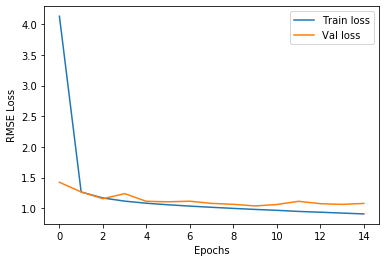

In [19]:
epochs = np.arange(1,len(val_losses))
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.show()

In [20]:
def init_hidden(batch_size, hidden_size):
    h = torch.zeros(batch_size,hidden_size, device=device)
    return (h,h)

model, optimizer, epoch, loss = trainer.load_model()
batch_test_loss = 0.0
model.eval()
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x,y = x.to(device), y.to(device)
        states = init_hidden(x.size()[0], x.size()[3]*x.size()[4])
        output = model(x, states)
        loss = criterion(output, y)
        batch_test_loss += loss.detach().item()
test_loss = batch_test_loss/len(test_loader)
loss_type = type(criterion).__name__
print(f'STConvS2S {loss_type}: {test_loss:.4f}')

STConvS2S RMSELoss: 1.0379


In [18]:
def init_hidden(batch_size, hidden_size):
    h = torch.zeros(batch_size,hidden_size, device=device)
    return (h,h)

trainer.path = '../../../models/CFSR/1_step/STTSModel_3D_m05d09-h17m42s24.pth.tar'
model, optimizer, epoch, loss = trainer.load_model()
batch_test_loss = 0.0
model.eval()
previous_three_steps = []

with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        for j in range(2,5):
            previous_three_steps.append(x[19,0,j,:,:])
        x,y = x.to(device), y.to(device)
        ground_truth = y[19,0,:,:]
        states = init_hidden(x.size()[0], x.size()[3]*x.size()[4])
        output = model(x, states)
        prediction = output[19,0,:,:]
        print(criterion(prediction, ground_truth))
        break

tensor(0.8898, device='cuda:0')


In [19]:
lat = dataset.variables['lat'][:]
lon = dataset.variables['lon'][:]
# extend longitude by 2
lon_extend = np.zeros(lon.size+2)
# fill in internal values
lon_extend[1:-1] = lon # fill up with original values
# fill in extra endpoints
lon_extend[0] = lon[0]-np.diff(lon)[0]
lon_extend[-1] = lon[-1]+np.diff(lon)[-1]
# calculate the midpoints
lon_pcolormesh_midpoints = lon_extend[:-1]+0.5*(np.diff(lon_extend))

# extend latitude by 2
lat_extend = np.zeros(lat.size+2)
# fill in internal values
lat_extend[1:-1] = lat
# fill in extra endpoints
lat_extend[0] = lat[0]-np.diff(lat)[0]
lat_extend[-1] = lat[-1]+np.diff(lat)[-1]
# calculate the midpoints
lat_pcolormesh_midpoints = lat_extend[:-1]+0.5*(np.diff(lat_extend))

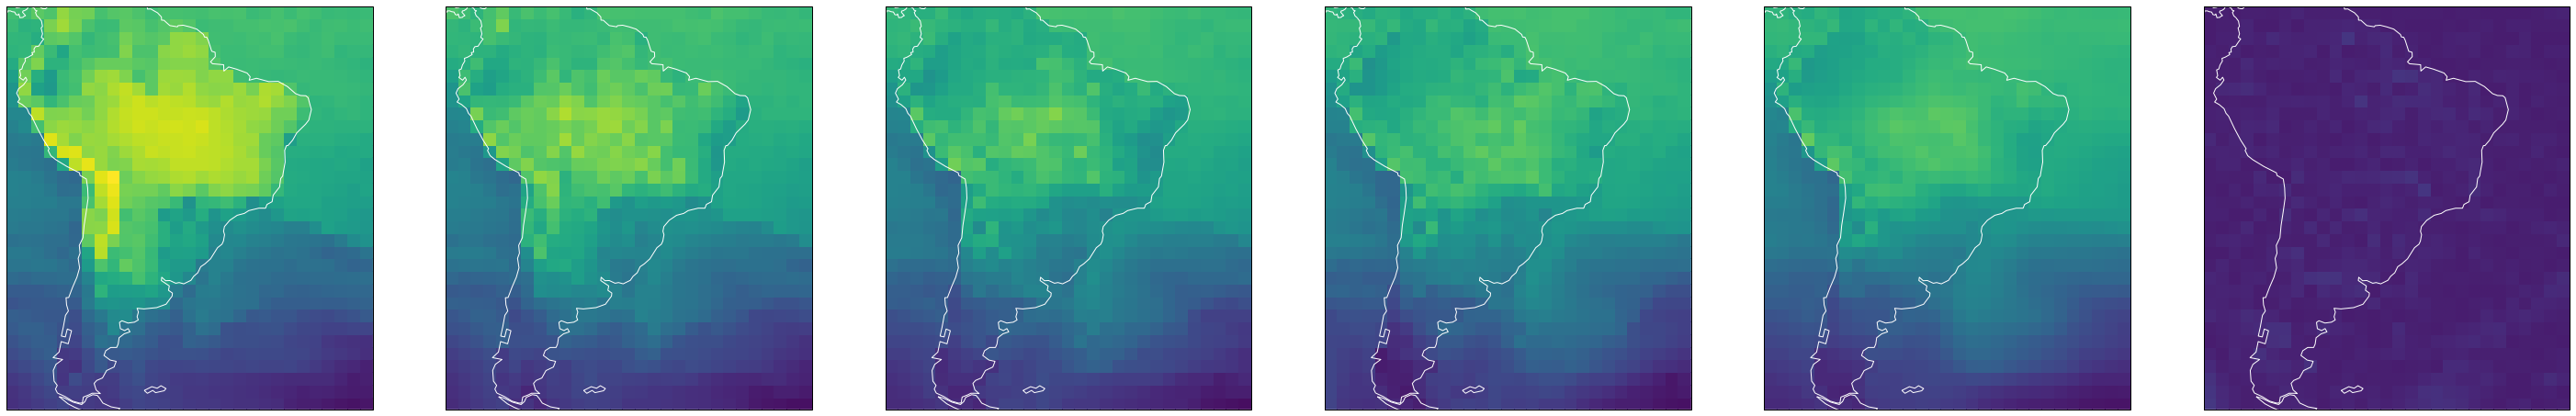

In [29]:
total = torch.cat((x[19,0,2,:,:],x[19,0,3,:,:],x[19,0,4,:,:],ground_truth,prediction))
min_val = torch.min(total).cpu()
max_val = torch.max(total).cpu()
fig = plt.figure(figsize=(50, 50))
sst = previous_three_steps[0].cpu()
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax1 = plt.subplot(1, 6, 1, projection=ccrs.PlateCarree())
ax1.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax1.coastlines(color='white')
ax1.set_extent([-83,-25,-51.5,8])

sst = previous_three_steps[1].cpu()
ax2 = plt.subplot(1, 6, 2, projection=ccrs.PlateCarree())
ax2.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax2.coastlines(color='white')
ax2.set_extent([-83,-25,-51.5,8])

sst = previous_three_steps[2].cpu()
ax3 = plt.subplot(1, 6, 3, projection=ccrs.PlateCarree())
ax3.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax3.coastlines(color='white')
ax3.set_extent([-83,-25,-51.5,8])

sst = ground_truth.cpu()
ax4 = plt.subplot(1, 6, 4, projection=ccrs.PlateCarree())
ax4.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax4.coastlines(color='white')
ax4.set_extent([-83,-25,-51.5,8])

sst = prediction.cpu()
ax5 = plt.subplot(1, 6, 5, projection=ccrs.PlateCarree())
ax5.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax5.coastlines(color='white')
ax5.set_extent([-83,-25,-51.5,8])
fig.tight_layout()

sst = abs(ground_truth-prediction).cpu()
ax5 = plt.subplot(1, 6, 6, projection=ccrs.PlateCarree())
ax5.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax5.coastlines(color='white')
ax5.set_extent([-83,-25,-51.5,8])
fig.tight_layout()
plt.show()
#plt.savefig('foo.pdf')

In [18]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np
def report_regression_results(y_true, y_pred):
    # Print multiple regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    adjusted_r2 =  1.0 - ( mse / y_true.var() )
    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('Adjusted r2: ', round(adjusted_r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    # save a plot with the residuals
    plt.scatter(y_pred,(y_true - y_pred),edgecolors='black')
    plt.title('Fitted vs. residuals plot')
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.show()
    f.savefig("report-experiment1.pdf", bbox_inches='tight')
    
def report_explained_variance(y_true, y_pred):
    batch, ch, lat, lon = y_true.shape
    explained_variance = 0
    for i in range(batch):
        explained_variance += metrics.explained_variance_score(y_true[i,0,:,:], y_pred[i,0,:,:])
    return explained_variance / (batch)

def report_r2(y_true, y_pred):
    batch, ch, lat, lon = y_true.shape
    r2 = 0
    ar2 = 0
    for i in range(batch):
        mse = metrics.mean_squared_error(y_true[i,0,:,:], y_pred[i,0,:,:]) 
        r2 += metrics.r2_score(y_true[i,0,:,:], y_pred[i,0,:,:])
        ar2 +=  1.0 - ( mse / y_true[i,0,:,:].var() )
    r2 = r2/(batch)
    ar2 = ar2/(batch)
    return r2, ar2

def plot_residual_fitted(y_true, y_pred):
    plt.scatter(y_pred,(y_true - y_pred), alpha=0.5)
    plt.title('ST-RFD')
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.show()

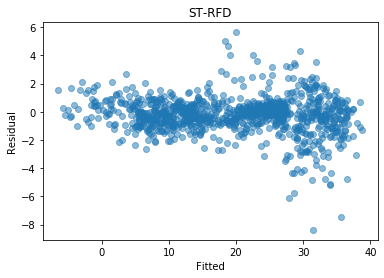

STConvS2S: 1.0379
Explained variance:  0.9829
r2:  0.9813
ar2:  0.9835


In [21]:
trainer.path = '../../../models/CFSR/1_step/STTSModel_3D_m05d09-h17m42s24.pth.tar'
model, optimizer, epoch, loss = trainer.load_model()
batch_test_loss = 0.0
batch_explained_variance = 0.0
batch_r2 = 0.0
batch_ar2 = 0.0
model.eval()
y_true = None
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x,y = x.to(device), y.to(device)
        states = trainer.init_hidden(x.size()[0], x.size()[3]*x.size()[4])
        output = model(x, states)
        loss = criterion(output, y)
        y_true = y.cpu().numpy()
        y_pred = output.cpu().numpy()
        if (i == 0):
            plot_residual_fitted(y_true[0,0,:,:], y_pred[0,0,:,:])
        batch_test_loss += loss.detach().item()
        batch_explained_variance += report_explained_variance(y_true, y_pred)
        r2, ar2 = report_r2(y_true, y_pred)
        batch_r2 += r2
        batch_ar2 += ar2
        
test_loss = batch_test_loss/len(test_loader)
explained_variance = batch_explained_variance/len(test_loader)
r2 = batch_r2/len(test_loader)
ar2 = batch_ar2/len(test_loader)
print(f'STConvS2S: {test_loss:.4f}')
print('Explained variance: ', round(explained_variance,4))
print('r2: ', round(r2,4))
print('ar2: ', round(ar2,4))

In [34]:
def init_hidden(batch_size, hidden_size):
    h = torch.zeros(batch_size,hidden_size, device=device)
    return (h,h)
states = init_hidden(25, 32*32)
trainer.path = '../../../models/CFSR/1_step/STTSModel_3D_m05d09-h17m42s24.pth.tar'
model, optimizer, epoch, loss = trainer.load_model()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)
print(summary(model, torch.zeros((25, 1, 5, 32, 32)).to(device), states, show_input=True))

8449216
------------------------------------------------------------------------------------------
      Layer (type)                            Input Shape         Param #     Tr. Param #
      EncoderCNN-1                       [125, 1, 32, 32]          52,416          52,416
        LSTMCell-2     [25, 1024], [25, 1024], [25, 1024]       8,396,800       8,396,800
        LSTMCell-3     [25, 1024], [25, 1024], [25, 1024]       8,396,800       8,396,800
        LSTMCell-4     [25, 1024], [25, 1024], [25, 1024]       8,396,800       8,396,800
        LSTMCell-5     [25, 1024], [25, 1024], [25, 1024]       8,396,800       8,396,800
        LSTMCell-6     [25, 1024], [25, 1024], [25, 1024]       8,396,800       8,396,800
      EncoderCNN-7                        [25, 1, 32, 32]          52,416          52,416
Total params: 42,088,832
Trainable params: 42,088,832
Non-trainable params: 0
------------------------------------------------------------------------------------------
